In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import matthews_corrcoef
import shap
import statsmodels.api as sm
from sklearn.feature_selection import chi2, f_classif
from sklearn.calibration import calibration_curve
from scipy.stats import wilcoxon
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.stats.multitest as multitest

In [90]:
dataset = pd.read_csv('ADNI_final_04_09_2020.csv')
dataset = dataset.drop(["FAQTOTAL"], axis = 1)
dataset = dataset.dropna()

## Encoding

In [88]:
le_gender = LabelEncoder()
le_ethnicity = LabelEncoder()
le_race = LabelEncoder()
le_marry = LabelEncoder()

dataset['PTGENDER'] = le_gender.fit_transform(dataset['PTGENDER'])
dataset['PTETHCAT'] = le_ethnicity.fit_transform(dataset['PTETHCAT'])
dataset['PTRACCAT'] = le_race.fit_transform(dataset['PTRACCAT'])
dataset['PTMARRY'] = le_marry.fit_transform(dataset['PTMARRY'])

## Splitting

In [4]:
x_faq = dataset.filter(items = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL"]).values
x_total = dataset.filter(items = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL","PTGENDER","PTEDUCAT","PTETHCAT","PTRACCAT","PTMARRY",
                                 "APOE4","long.age"]).values

y = dataset.filter(regex=("DX$")).values

In [89]:
le = LabelEncoder()
y = le.fit_transform(y)

## Random Forest

In [6]:
RF = RandomForestClassifier(random_state = 1)

In [7]:
p_grid = {"n_estimators" : [100,300,500,800],
         "min_samples_split" : [2,5,10,15],
         "min_samples_leaf" : [1, 2, 5, 10]}

In [11]:
clf = GridSearchCV(estimator = RF, param_grid = p_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
clf_fit = clf.fit(x_faq,y).predict_proba(x_faq)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.7min finished


In [12]:
feature_importances = permutation_importance(clf, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [13]:
feature_names_faq = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL"]
indices = np.argsort(feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in indices:
    scores.append(feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], feature_importances.importances_mean[i]))

FAQTRAVL: 0.077
FAQREM: 0.038
FAQGAME: 0.038
FAQMEAL: 0.035
FAQFORM: 0.034
FAQSHOP: 0.031
FAQEVENT: 0.029
FAQFINAN: 0.025
FAQTV: 0.024
FAQBEVG: 0.021


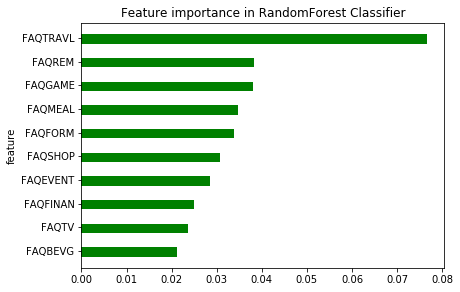

<Figure size 360x360 with 0 Axes>

In [14]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

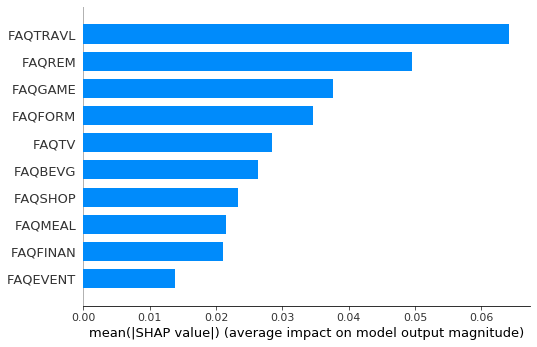

In [15]:
shap_values = shap.TreeExplainer(clf.best_estimator_).shap_values(x_faq)
shap.summary_plot(shap_values[0], x_faq,feature_names = feature_names_faq,plot_type = "bar")

## Gradient Boosting

In [8]:
GB = GradientBoostingClassifier(random_state = 1)

In [9]:
gb_grid = {"n_estimators" : [100,300,500,800],
         "min_samples_split" : [2,5,10,15],
         "min_samples_leaf" : [1,2,5,10],
          "learning_rate": [0.01,0.05,0.1]}

In [18]:
gbf = GridSearchCV(estimator = GB, param_grid = gb_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
gbf_fit = gbf.fit(x_faq,y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1814 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.4min finished


In [19]:
gb_feature_importances = permutation_importance(gbf_fit, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [20]:
feature_names_faq = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL"]
gb_indices = np.argsort(gb_feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices:
    scores.append(gb_feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], gb_feature_importances.importances_mean[i]))

FAQTRAVL: 0.069
FAQGAME: 0.034
FAQREM: 0.024
FAQSHOP: 0.017
FAQMEAL: 0.015
FAQFORM: 0.014
FAQBEVG: 0.013
FAQTV: 0.011
FAQFINAN: 0.005
FAQEVENT: 0.005


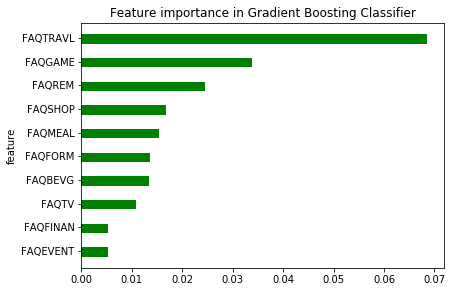

<Figure size 360x360 with 0 Axes>

In [21]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Gradient Boosting Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [22]:
gb_shap_values = shap.TreeExplainer(gbf.best_estimator_).shap_values(x_faq)

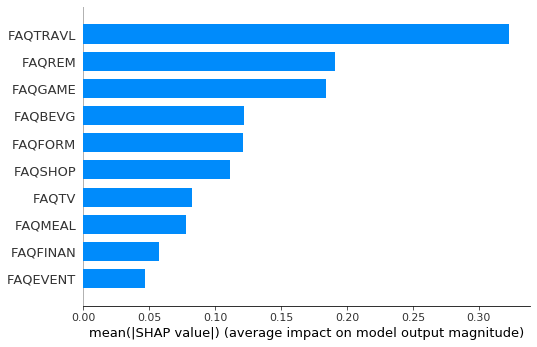

In [23]:
shap.summary_plot(gb_shap_values, x_faq,feature_names = feature_names_faq,plot_type = "bar")

## Logistic Regression

In [10]:
LR = LogisticRegression()

In [11]:
lr_grid = {"penalty":["l1","l2"],
          "C":np.logspace(-4,4,20),
          "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          "max_iter":[100,1000,2500,5000]}

In [37]:
lrf = GridSearchCV(estimator = LR, param_grid = lr_grid, cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
lrf_fit = lrf.fit(x_faq,y)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6400 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:    5.5s finished


In [40]:
lr_feature_importances = permutation_importance(lrf_fit, x_faq, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [41]:
feature_names_faq = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL"]
lr_indices = np.argsort(lr_feature_importances.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices:
    scores.append(lr_feature_importances.importances_mean[i])
    ticks.append(feature_names_faq[i])
    print("{}: {:.3f}".format(feature_names_faq[i], lr_feature_importances.importances_mean[i]))

FAQTRAVL: 0.054
FAQGAME: 0.016
FAQREM: 0.018
FAQSHOP: 0.000
FAQMEAL: 0.006
FAQFORM: 0.010
FAQBEVG: 0.002
FAQTV: 0.001
FAQFINAN: -0.000
FAQEVENT: 0.000


## Nested Cross Validation

In [19]:
outer_cv = 10

#Metrics to calculate

specificity = make_scorer(recall_score, pos_label=0)
sensitivity = make_scorer(recall_score, pos_label=1)
mcc = make_scorer(matthews_corrcoef)

s_dict = {"specificity" : make_scorer(recall_score, pos_label=0),
         "sensitivity" : make_scorer(recall_score, pos_label=1),
         "mcc":make_scorer(matthews_corrcoef)}

scores = {'accuracy' : 'accuracy',
         'precision' : 'precision',
          "roc":'roc_auc',
          "balanced_acc":"balanced_accuracy",
         "specificity" : s_dict["specificity"],
         "sensitivity" : s_dict["sensitivity"],
         "MCC":s_dict["mcc"],
         "f1_score":"f1"}

In [48]:
#Random Forest
rf_nested_scores = cross_validate(estimator = clf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/maborageh/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 13.7min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.4min finished


In [25]:
rf_class_probabilities = cross_val_predict(estimator = clf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/maborageh/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 13.7min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.4min finished


In [49]:
gb_nested_scores = cross_validate(estimator = gbf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 24.7min remaining: 16.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 42.2min finished


In [26]:
gb_class_probabilities = cross_val_predict(estimator = gbf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 24.8min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 42.1min finished


In [50]:
lr_nested_scores = cross_validate(estimator = lrf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   47.5s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


In [42]:
lr_class_probabilities = cross_val_predict(estimator = lrf, X = x_faq, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   47.1s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


In [28]:
rf_proba = rf_class_probabilities[:,1]

rf_fraction_of_positives, rf_mean_predicted_value = calibration_curve(y, rf_proba, n_bins=10)

In [29]:
gb_proba = gb_class_probabilities[:,1]

gb_fraction_of_positives, gb_mean_predicted_value = calibration_curve(y, gb_proba, n_bins=10)

In [43]:
lr_proba = lr_class_probabilities[:,1]

lr_fraction_of_positives, lr_mean_predicted_value = calibration_curve(y, lr_proba, n_bins=10)

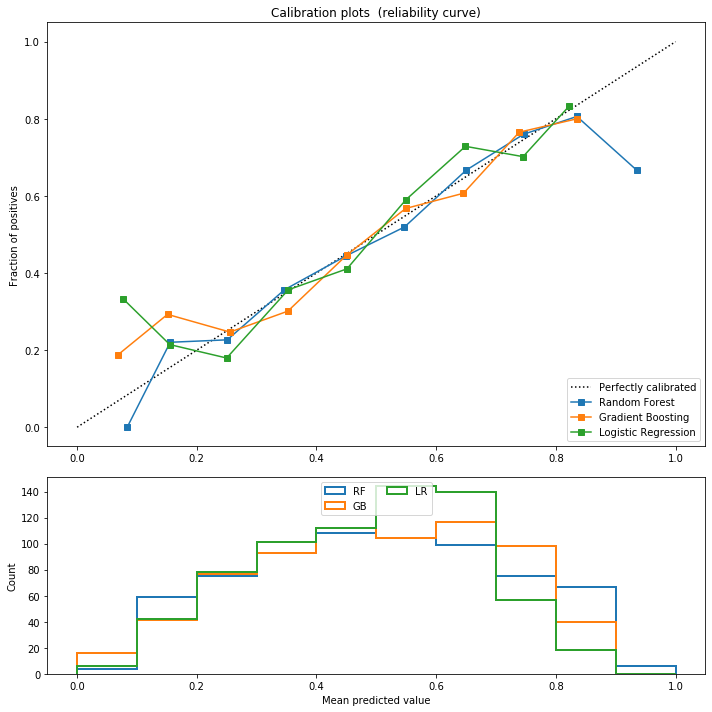

In [45]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(rf_mean_predicted_value, rf_fraction_of_positives, "s-",
             label="%s" % ("Random Forest", ))
ax1.plot(gb_mean_predicted_value, gb_fraction_of_positives, "s-",
             label="%s" % ("Gradient Boosting", ))
ax1.plot(lr_mean_predicted_value, lr_fraction_of_positives, "s-",
             label="%s" % ("Logistic Regression", ))


ax2.hist(rf_proba, range=(0, 1), bins=10, label="RF",
             histtype="step", lw=2)
ax2.hist(gb_proba, range=(0, 1), bins=10, label="GB",
             histtype="step", lw=2)
ax2.hist(lr_proba, range=(0, 1), bins=10, label="LR",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [52]:
print("Accuracy:", statistics.mean(rf_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(rf_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(rf_nested_scores['test_precision']))
print("Specificity:", statistics.mean(rf_nested_scores['test_specificity']))
print("Sensitivity:", statistics.mean(rf_nested_scores['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(rf_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(rf_nested_scores['test_f1_score']))
print("ROC:", statistics.mean(rf_nested_scores['test_roc']))

Accuracy: 0.6705797101449276
Balanced Accuracy: 0.6705042016806723
Precision: 0.6725051284063592
Specificity: 0.667563025210084
Sensitivity: 0.6734453781512605
Matthews Correlation Coefficient: 0.34338788147220456
F1 Score: 0.6703906106302672
ROC: 0.7292232893157262


In [53]:
print("Accuracy:", statistics.mean(gb_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(gb_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(gb_nested_scores['test_precision']))
print("Sensitivity:", statistics.mean(gb_nested_scores['test_sensitivity']))
print("Specificity:", statistics.mean(gb_nested_scores['test_specificity']))
print("Matthews Correlation Coefficient:", statistics.mean(gb_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(gb_nested_scores['test_f1_score']))
print("ROC", statistics.mean(gb_nested_scores['test_roc']))

Accuracy: 0.6650517598343685
Balanced Accuracy: 0.6650420168067227
Precision: 0.6636683713559981
Sensitivity: 0.6793277310924369
Specificity: 0.6507563025210084
Matthews Correlation Coefficient: 0.3313649650034773
F1 Score: 0.6699936886294907
ROC 0.721235294117647


In [51]:
print("Accuracy:", statistics.mean(lr_nested_scores['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(lr_nested_scores['test_balanced_acc']))
print("Precision:", statistics.mean(lr_nested_scores['test_precision']))
print("Sensitivity:", statistics.mean(lr_nested_scores['test_sensitivity']))
print("Specificity:", statistics.mean(lr_nested_scores['test_specificity']))
print("Matthews Correlation Coefficient:", statistics.mean(lr_nested_scores['test_MCC']))
print("F1 Score:", statistics.mean(lr_nested_scores['test_f1_score']))
print("ROC", statistics.mean(lr_nested_scores['test_roc']))

Accuracy: 0.6792132505175983
Balanced Accuracy: 0.6792016806722689
Precision: 0.6791699794478546
Sensitivity: 0.6933613445378152
Specificity: 0.6650420168067227
Matthews Correlation Coefficient: 0.36196263345861485
F1 Score: 0.6832972366989193
ROC 0.7345390156062425


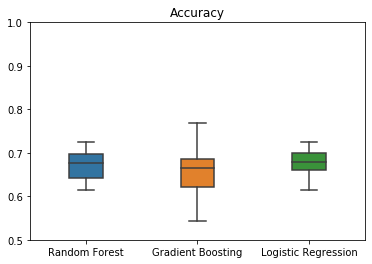

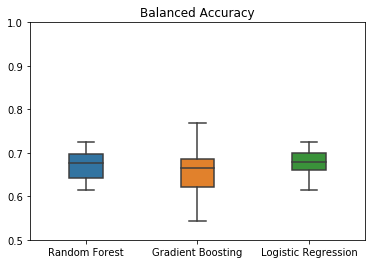

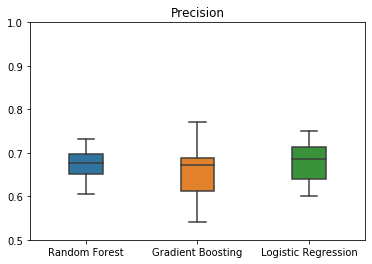

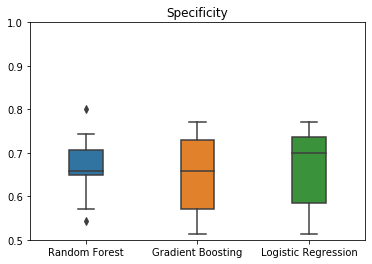

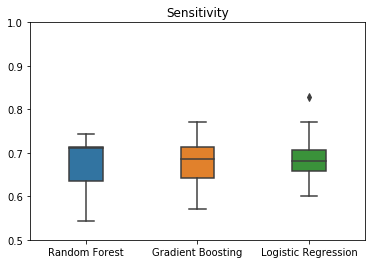

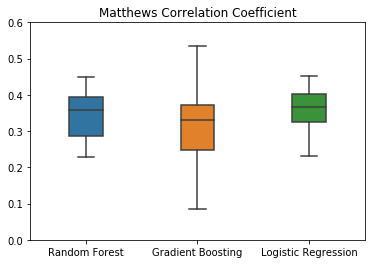

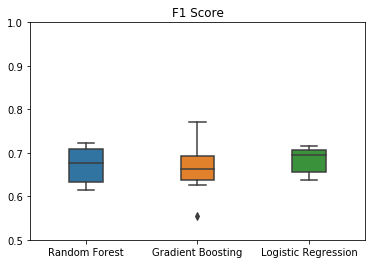

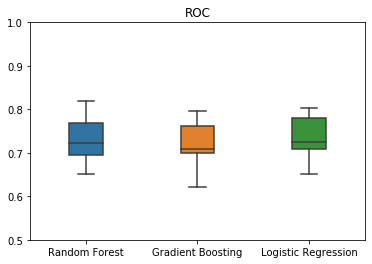

In [57]:
rf_acc = rf_nested_scores['test_accuracy']
gb_acc = gb_nested_scores['test_accuracy']
lr_acc = lr_nested_scores['test_accuracy']
sns.boxplot(data = [rf_acc,gb_acc,lr_acc], width = 0.3).set_title("Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_ba_acc = rf_nested_scores['test_balanced_acc']
gb_ba_acc = gb_nested_scores['test_balanced_acc']
lr_ba_acc = lr_nested_scores['test_balanced_acc']
sns.boxplot(data = [rf_ba_acc,gb_ba_acc,lr_ba_acc], width = 0.3).set_title("Balanced Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_precision = rf_nested_scores['test_precision']
gb_precision = gb_nested_scores['test_precision']
lr_precision = lr_nested_scores['test_precision']
sns.boxplot(data = [rf_precision,gb_precision,lr_precision], width = 0.3).set_title("Precision")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_spec = rf_nested_scores['test_specificity']
gb_spec = gb_nested_scores['test_specificity']
lr_spec = lr_nested_scores['test_specificity']
sns.boxplot(data = [rf_spec,gb_spec,lr_spec], width = 0.3).set_title("Specificity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_sens = rf_nested_scores['test_sensitivity']
gb_sens = gb_nested_scores['test_sensitivity']
lr_sens = lr_nested_scores['test_sensitivity']
sns.boxplot(data = [rf_sens,gb_sens,lr_sens], width = 0.3).set_title("Sensitivity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_mcc = rf_nested_scores['test_MCC']
gb_mcc = gb_nested_scores['test_MCC']
lr_mcc = lr_nested_scores['test_MCC']
sns.boxplot(data = [rf_mcc,gb_mcc,lr_mcc], width = 0.3).set_title("Matthews Correlation Coefficient")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0,0.6)
plt.show()

rf_f1 = rf_nested_scores['test_f1_score']
gb_f1 = gb_nested_scores['test_f1_score']
lr_f1 = lr_nested_scores['test_f1_score']
sns.boxplot(data = [rf_f1,gb_f1,lr_f1], width = 0.3).set_title("F1 Score")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_roc = rf_nested_scores['test_roc']
gb_roc = gb_nested_scores['test_roc']
lr_roc = lr_nested_scores['test_roc']
sns.boxplot(data = [rf_roc,gb_roc,lr_roc], width = 0.3).set_title("ROC")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

## Model Implementation with FAQ & Demographic information

### Random Forest

In [46]:
clf_total = GridSearchCV(estimator = RF, param_grid = p_grid,
                         cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
clf_total_fit = clf_total.fit(x_total,y)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.0min finished


In [47]:
feature_importances_total = permutation_importance(clf_total_fit, x_total,
                                                   y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [48]:
feature_names_total = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL","PTGENDER","PTEDUCAT","PTETHCAT","PTRACCAT","PTMARRY",
                                 "APOE4","long.age"]
indices_total = np.argsort(feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in indices_total:
    scores.append(feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], feature_importances_total.importances_mean[i]))

FAQTRAVL: 0.067
long.age: 0.066
FAQREM: 0.040
FAQGAME: 0.035
FAQFORM: 0.029
FAQMEAL: 0.027
FAQSHOP: 0.025
PTEDUCAT: 0.024
FAQFINAN: 0.023
FAQEVENT: 0.022
FAQTV: 0.022
FAQBEVG: 0.018
APOE4: 0.014
PTGENDER: 0.010
PTMARRY: 0.005
PTETHCAT: 0.001
PTRACCAT: 0.001


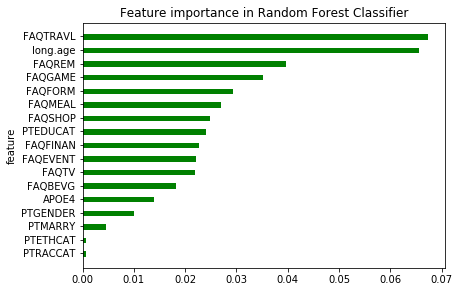

<Figure size 360x360 with 0 Axes>

In [49]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Random Forest Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

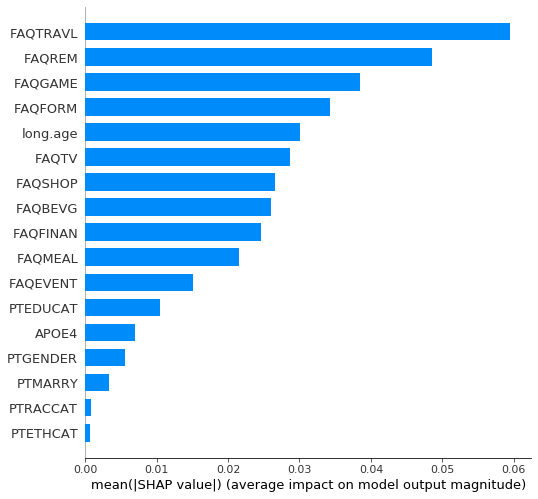

In [50]:
shap_values = shap.TreeExplainer(clf_total.best_estimator_).shap_values(x_total)
shap.summary_plot(shap_values[0], x_total,feature_names = feature_names_total,plot_type = "bar")

### Gradient Boosting

In [51]:
gbf_total = GridSearchCV(estimator = GB, param_grid = gb_grid,
                   cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
gbf_total_fit = gbf_total.fit(x_total,y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1810 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  3.0min finished


In [52]:
gb_feature_importances_total = permutation_importance(gbf_total_fit, x_total, y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [53]:
feature_names_total = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL","PTGENDER","PTEDUCAT","PTETHCAT","PTRACCAT","PTMARRY",
                                 "APOE4","long.age"]
gb_indices_total = np.argsort(gb_feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in gb_indices_total:
    scores.append(gb_feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], gb_feature_importances_total.importances_mean[i]))

FAQTRAVL: 0.076
FAQGAME: 0.024
FAQREM: 0.023
FAQSHOP: 0.020
FAQFORM: 0.017
long.age: 0.012
FAQBEVG: 0.007
FAQMEAL: 0.006
FAQTV: 0.005
PTETHCAT: 0.002
PTGENDER: 0.001
FAQEVENT: 0.001
FAQFINAN: 0.000
PTEDUCAT: 0.000
APOE4: 0.000
PTRACCAT: 0.000
PTMARRY: 0.000


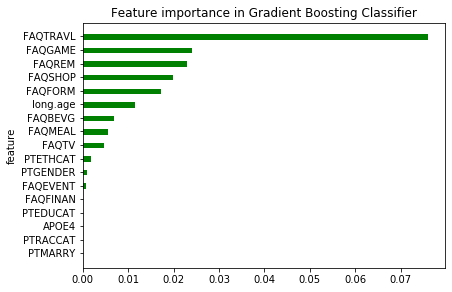

<Figure size 360x360 with 0 Axes>

In [54]:
fig, ax = plt.subplots() 
width = 0.4
ind = np.arange(len(scores))
ax.barh(ind, scores[::-1], width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(ticks[::-1], minor=False)
plt.title("Feature importance in Gradient Boosting Classifier")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

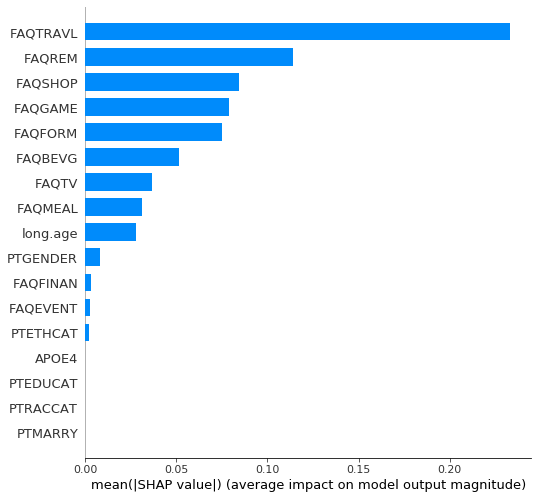

In [55]:
gb_shap_values = shap.TreeExplainer(gbf_total.best_estimator_).shap_values(x_total)
shap.summary_plot(gb_shap_values, x_total,feature_names = feature_names_total,plot_type = "bar")

### Logistic Regression

In [17]:
lr_grid_2 = {"penalty":["l1","l2"],
          "C":np.logspace(-4,4,20),
          "solver":['newton-cg', 'lbfgs','sag', 'saga'],
          "max_iter":[8000,10000]}
lrf_total = GridSearchCV(estimator = LR, param_grid = lr_grid_2,
                   cv = StratifiedKFold(n_splits = 10),n_jobs = -1, verbose = 1)
lrf_total_fit = lrf_total.fit(x_total,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2076 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 2740 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:   58.4s finished


In [87]:
lr_feature_importances_total = permutation_importance(lrf_total_fit, x_total,
                                                      y, n_repeats=10, random_state=0,scoring = "roc_auc")

In [88]:
feature_names_total = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL","PTGENDER","PTEDUCAT","PTETHCAT","PTRACCAT","PTMARRY",
                                 "APOE4","long.age"]
lr_indices_total = np.argsort(lr_feature_importances_total.importances_mean)[::-1]
scores = []
ticks = []
for i in lr_indices_total:
    scores.append(lr_feature_importances_total.importances_mean[i])
    ticks.append(feature_names_total[i])
    print("{}: {:.3f}".format(feature_names_total[i], lr_feature_importances_total.importances_mean[i]))

FAQTRAVL: 0.026
FAQGAME: 0.008
FAQREM: 0.008
FAQSHOP: 0.004
FAQFORM: 0.008
long.age: -0.001
FAQBEVG: 0.002
FAQMEAL: 0.007
FAQTV: 0.002
PTETHCAT: -0.000
PTGENDER: 0.000
FAQEVENT: 0.003
FAQFINAN: 0.004
PTEDUCAT: 0.002
APOE4: 0.000
PTRACCAT: -0.000
PTMARRY: -0.000


## Nested Cross Validation

In [20]:
rf_class_probabilities_total = cross_val_predict(estimator = clf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 14.1min remaining:  9.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.6min finished


In [21]:
gb_class_probabilities_total = cross_val_predict(estimator = gbf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 26.4min remaining: 17.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 44.1min finished


In [22]:
lr_class_probabilities_total = cross_val_predict(estimator = lrf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv)
                                        ,method = "predict_proba", n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  7.5min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.4min finished


In [24]:
rf_proba_total = rf_class_probabilities_total[:,1]

rf_fraction_of_positives_total, rf_mean_predicted_value_total = calibration_curve(y, rf_proba_total, n_bins=10)

In [25]:
gb_proba_total = gb_class_probabilities_total[:,1]

gb_fraction_of_positives_total, gb_mean_predicted_value_total = calibration_curve(y, gb_proba_total, n_bins=10)

In [26]:
lr_proba_total = lr_class_probabilities_total[:,1]

lr_fraction_of_positives_total, lr_mean_predicted_value_total = calibration_curve(y, lr_proba_total, n_bins=10)

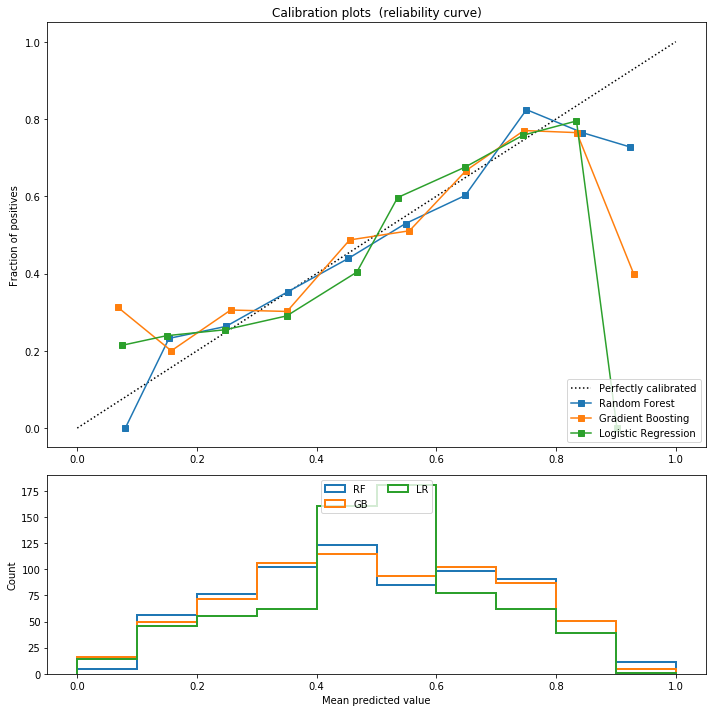

In [29]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(rf_mean_predicted_value_total, rf_fraction_of_positives_total, "s-",
             label="%s" % ("Random Forest", ))
ax1.plot(gb_mean_predicted_value_total, gb_fraction_of_positives_total, "s-",
             label="%s" % ("Gradient Boosting", ))
ax1.plot(lr_mean_predicted_value_total, lr_fraction_of_positives_total, "s-",
             label="%s" % ("Logistic Regression", ))


ax2.hist(rf_proba_total, range=(0, 1), bins=10, label="RF",
             histtype="step", lw=2)
ax2.hist(gb_proba_total, range=(0, 1), bins=10, label="GB",
             histtype="step", lw=2)
ax2.hist(lr_proba_total, range=(0, 1), bins=10, label="LR",
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [30]:
rf_nested_scores_total = cross_validate(estimator = clf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 14.3min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 22.9min finished


In [31]:
gb_nested_scores_total = cross_validate(estimator = gbf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 26.5min remaining: 17.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 44.2min finished


In [32]:
lr_nested_scores_total = cross_validate(estimator = lrf_total, X = x_total, y = y,cv = StratifiedKFold(n_splits = outer_cv),
                          scoring = scores, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  7.5min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.5min finished


In [33]:
print("Accuracy:", statistics.mean(rf_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(rf_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(rf_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(rf_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(rf_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(rf_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(rf_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(rf_nested_scores_total['test_roc']))

Accuracy: 0.6663354037267081
Balanced Accuracy: 0.666344537815126
Precision: 0.6742000574817912
Specificity: 0.6849579831932773
Sensitivity: 0.6477310924369748
Matthews Correlation Coefficient: 0.3343801391537651
F1 Score: 0.6591310924861453
ROC: 0.7256014405762305


In [34]:
print("Accuracy:", statistics.mean(gb_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(gb_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(gb_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(gb_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(gb_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(gb_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(gb_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(gb_nested_scores_total['test_roc']))

Accuracy: 0.6563975155279503
Balanced Accuracy: 0.656344537815126
Precision: 0.6611013061285294
Specificity: 0.670672268907563
Sensitivity: 0.642016806722689
Matthews Correlation Coefficient: 0.31413534473408733
F1 Score: 0.6497628682759856
ROC: 0.7177635054021609


In [35]:
print("Accuracy:", statistics.mean(lr_nested_scores_total['test_accuracy']))
print("Balanced Accuracy:", statistics.mean(lr_nested_scores_total['test_balanced_acc']))
print("Precision:", statistics.mean(lr_nested_scores_total['test_precision']))
print("Specificity:", statistics.mean(lr_nested_scores_total['test_specificity']))
print("Sensitivity:", statistics.mean(lr_nested_scores_total['test_sensitivity']))
print("Matthews Correlation Coefficient:", statistics.mean(lr_nested_scores_total['test_MCC']))
print("F1 Score:", statistics.mean(lr_nested_scores_total['test_f1_score']))
print("ROC:", statistics.mean(lr_nested_scores_total['test_roc']))

Accuracy: 0.6663561076604555
Balanced Accuracy: 0.666344537815126
Precision: 0.6620205575230567
Specificity: 0.6447899159663866
Sensitivity: 0.6878991596638655
Matthews Correlation Coefficient: 0.3337695724652204
F1 Score: 0.6736662406540577
ROC: 0.7298943577430972


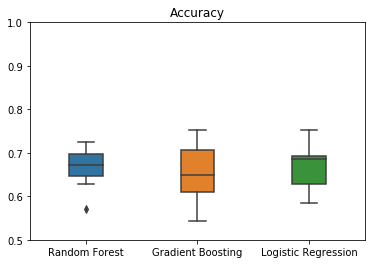

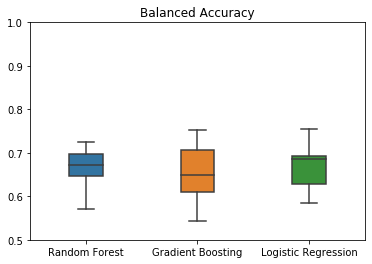

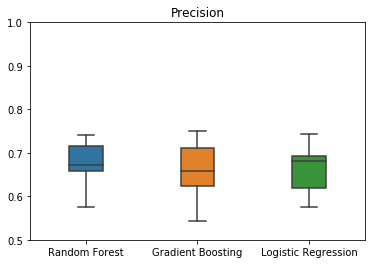

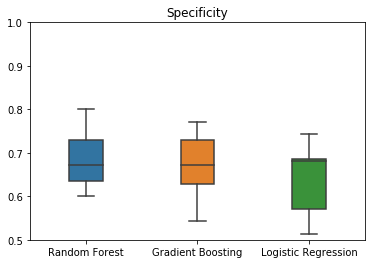

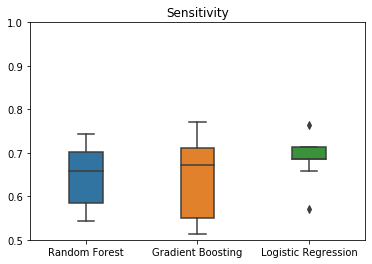

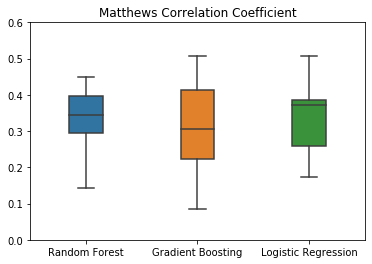

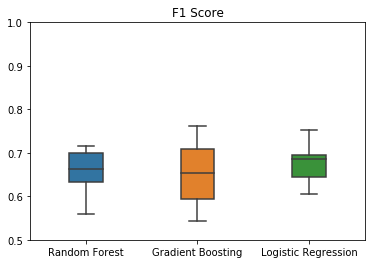

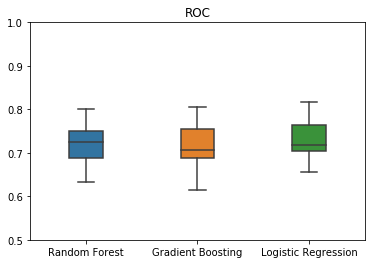

In [36]:
rf_acc = rf_nested_scores_total['test_accuracy']
gb_acc = gb_nested_scores_total['test_accuracy']
lr_acc = lr_nested_scores_total['test_accuracy']
sns.boxplot(data = [rf_acc,gb_acc,lr_acc], width = 0.3).set_title("Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_ba_acc = rf_nested_scores_total['test_balanced_acc']
gb_ba_acc = gb_nested_scores_total['test_balanced_acc']
lr_ba_acc = lr_nested_scores_total['test_balanced_acc']
sns.boxplot(data = [rf_ba_acc,gb_ba_acc,lr_ba_acc], width = 0.3).set_title("Balanced Accuracy")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_precision = rf_nested_scores_total['test_precision']
gb_precision = gb_nested_scores_total['test_precision']
lr_precision = lr_nested_scores_total['test_precision']
sns.boxplot(data = [rf_precision,gb_precision,lr_precision], width = 0.3).set_title("Precision")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_spec = rf_nested_scores_total['test_specificity']
gb_spec = gb_nested_scores_total['test_specificity']
lr_spec = lr_nested_scores_total['test_specificity']
sns.boxplot(data = [rf_spec,gb_spec,lr_spec], width = 0.3).set_title("Specificity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_sens = rf_nested_scores_total['test_sensitivity']
gb_sens = gb_nested_scores_total['test_sensitivity']
lr_sens = lr_nested_scores_total['test_sensitivity']
sns.boxplot(data = [rf_sens,gb_sens,lr_sens], width = 0.3).set_title("Sensitivity")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_mcc = rf_nested_scores_total['test_MCC']
gb_mcc = gb_nested_scores_total['test_MCC']
lr_mcc = lr_nested_scores_total['test_MCC']
sns.boxplot(data = [rf_mcc,gb_mcc,lr_mcc], width = 0.3).set_title("Matthews Correlation Coefficient")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0,0.6)
plt.show()

rf_f1 = rf_nested_scores_total['test_f1_score']
gb_f1 = gb_nested_scores_total['test_f1_score']
lr_f1 = lr_nested_scores_total['test_f1_score']
sns.boxplot(data = [rf_f1,gb_f1,lr_f1], width = 0.3).set_title("F1 Score")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

rf_roc = rf_nested_scores_total['test_roc']
gb_roc = gb_nested_scores_total['test_roc']
lr_roc = lr_nested_scores_total['test_roc']
sns.boxplot(data = [rf_roc,gb_roc,lr_roc], width = 0.3).set_title("ROC")
plt.xticks([0,1,2], ["Random Forest","Gradient Boosting","Logistic Regression"])
plt.ylim(0.5,1)
plt.show()

In [57]:
feat_names = dataset.filter(items = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL"]).columns
mci = dataset.loc[dataset['DX'] == "MCI"]
ad = dataset.loc[dataset['DX'] == "Dementia"]
for i in feat_names:
    print(i)
    stat, p = wilcoxon(mci[i], ad[i])
    print('Statistics=%.3f, p=%.20f' % (stat, p))

FAQFINAN
Statistics=2474.000, p=0.00000000000000000001
FAQFORM
Statistics=1934.000, p=0.00000000000000000001
FAQSHOP
Statistics=2004.000, p=0.00000000000000000000
FAQGAME
Statistics=2098.000, p=0.00000000000000000187
FAQBEVG
Statistics=602.000, p=0.00000000000149080774
FAQMEAL
Statistics=2138.500, p=0.00000000000000062092
FAQEVENT
Statistics=2804.000, p=0.00000000000000014859
FAQTV
Statistics=2537.000, p=0.00000000000000778594
FAQREM
Statistics=2468.500, p=0.00000000000000000000
FAQTRAVL
Statistics=1820.500, p=0.00000000000000000000


In [78]:
feat_names = dataset.filter(items = ["FAQFINAN","FAQFORM","FAQSHOP","FAQGAME","FAQBEVG","FAQMEAL","FAQEVENT",
                      "FAQTV","FAQREM","FAQTRAVL"]).columns
mci = dataset.loc[dataset['DX'] == "MCI"]
ad = dataset.loc[dataset['DX'] == "Dementia"]
p_vals = []
for i in feat_names:
    stat, p = wilcoxon(mci[i], ad[i])
    p_vals.append(p)
    
p_val_corrected = multitest.multipletests(p_vals, method='fdr_bh')
p_val_corrected[1]

for i in range(0,len(feat_names)):
    print(feat_names[i], p_val_corrected[1][i])

FAQFINAN 1.7039108604176743e-20
FAQFORM 1.5010025732954272e-20
FAQSHOP 2.8054274477885244e-21
FAQGAME 3.1156481244712683e-18
FAQBEVG 1.4908077400973793e-12
FAQMEAL 7.761459855360856e-16
FAQEVENT 2.1227148487109697e-16
FAQTV 8.651038932999071e-15
FAQREM 1.5007402361174412e-22
FAQTRAVL 2.6280198759670305e-27
